#                                           Group 9 / Neural Geeks
                                            Kyle Riener - 1443856
                                            Sofia Kenny -  0963051
                                            Srinivasan Vasudevan - 1455328
                                            Elva Shen -  1414646
                                            Greg Murray - 
Title : Simple Question And Answering System
dataset: bAbi dataset
Date: DEC 5th 2018

In [1]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re
import os, fnmatch,glob,pathlib
from keras.layers import Bidirectional
import tensorflow as tf

c:\users\kyle\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Preprocessing

In [2]:
TEXT_DATA_DIR = '.'
path = TEXT_DATA_DIR
def tokenize(sent):
    '''Tokenize the data'''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]

In [3]:
def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data

In [4]:
def get_stories(fi, only_supporting=False, max_length=None):
    '''Read in file and convert to single story'''
    print(fi)
    f = open(fi)
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    f.close
    return data

In [5]:
def vectorize_stories(data):
    '''Break out story to context, question, and answer
    and pad context and question
    '''
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([word_idx[w] for w in story])
        queries.append([word_idx[w] for w in query])
        answers.append(word_idx[answer])
    return (pad_sequences(inputs, maxlen=story_maxlen),
            pad_sequences(queries, maxlen=query_maxlen),
            np.array(answers))

In [6]:
# we will only use qa1 data
trainpattern='qa1_train.txt'
testpattern='qa1_test.txt'

# Read in files
trainfiles=fnmatch.filter(os.listdir(TEXT_DATA_DIR), trainpattern)
testfiles=fnmatch.filter(os.listdir(TEXT_DATA_DIR), testpattern)
for f in trainfiles:
    train_stories = get_stories(os.path.join(TEXT_DATA_DIR, f))
for f in testfiles:
    test_stories = get_stories(os.path.join(TEXT_DATA_DIR, f))

# Build the vocabulary from our data
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

# Print details of our data
print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories)

print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')

.\qa1_train.txt


c:\users\kyle\anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


.\qa1_test.txt
-
Vocab size: 22 unique words
Story max length: 68 words
Query max length: 4 words
Number of training stories: 9000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...
-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (9000, 68)
inputs_test shape: (1000, 68)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (9000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (9000,)
answers_test shape: (1000,)
-
Compiling...


# Build Model with BIDIR

In [7]:
from keras import regularizers
from keras.layers import BatchNormalization
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# BiDirectional layer
answer = Bidirectional(LSTM(96, dropout=.2))(answer)

answer = Dense(vocab_size, kernel_regularizer=regularizers.l1(.0001), activation='relu')(answer)  # (samples, vocab_size)

answer = Dense(vocab_size, kernel_regularizer=regularizers.l2(.0001))(answer)
# output: probability that each word in vocab is the answer

answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



# train
history = model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=140,
          validation_data=([inputs_test, queries_test], answers_test))

Train on 9000 samples, validate on 1000 samples
Epoch 1/140
9000/9000 [==============================] - 9s 981us/step - loss: 1.9441 - acc: 0.1690 - val_loss: 1.8429 - val_acc: 0.1570
Epoch 2/140
9000/9000 [==============================] - 5s 517us/step - loss: 1.7675 - acc: 0.2169 - val_loss: 1.6561 - val_acc: 0.2730
Epoch 3/140
9000/9000 [==============================] - 5s 507us/step - loss: 1.6071 - acc: 0.3263 - val_loss: 1.5403 - val_acc: 0.3310
Epoch 4/140
9000/9000 [==============================] - 4s 487us/step - loss: 1.5405 - acc: 0.3597 - val_loss: 1.5021 - val_acc: 0.3660
Epoch 5/140
9000/9000 [==============================] - 5s 512us/step - loss: 1.5142 - acc: 0.3856 - val_loss: 1.4530 - val_acc: 0.4410
Epoch 6/140
9000/9000 [==============================] - 5s 513us/step - loss: 1.4729 - acc: 0.3996 - val_loss: 1.4148 - val_acc: 0.4020
Epoch 7/140
9000/9000 [==============================] - 4s 500us/step - loss: 1.4312 - acc: 0.4227 - val_loss: 1.4003 - val_acc: 

Epoch 60/140
9000/9000 [==============================] - 5s 521us/step - loss: 0.1887 - acc: 0.9454 - val_loss: 0.3730 - val_acc: 0.8830
Epoch 61/140
9000/9000 [==============================] - 5s 511us/step - loss: 0.1743 - acc: 0.9482 - val_loss: 0.3675 - val_acc: 0.8780
Epoch 62/140
9000/9000 [==============================] - 4s 480us/step - loss: 0.1766 - acc: 0.9476 - val_loss: 0.3518 - val_acc: 0.8950
Epoch 63/140
9000/9000 [==============================] - 5s 512us/step - loss: 0.1794 - acc: 0.9492 - val_loss: 0.3642 - val_acc: 0.8910
Epoch 64/140
9000/9000 [==============================] - 5s 519us/step - loss: 0.1589 - acc: 0.9538 - val_loss: 0.3689 - val_acc: 0.8860
Epoch 65/140
9000/9000 [==============================] - 5s 512us/step - loss: 0.1573 - acc: 0.9563 - val_loss: 0.3708 - val_acc: 0.8890
Epoch 66/140
9000/9000 [==============================] - 4s 476us/step - loss: 0.1664 - acc: 0.9539 - val_loss: 0.3374 - val_acc: 0.9060
Epoch 67/140
9000/9000 [==========

Epoch 119/140
9000/9000 [==============================] - 5s 505us/step - loss: 0.0802 - acc: 0.9812 - val_loss: 0.3110 - val_acc: 0.9290
Epoch 120/140
9000/9000 [==============================] - 5s 505us/step - loss: 0.0805 - acc: 0.9811 - val_loss: 0.3119 - val_acc: 0.9210
Epoch 121/140
9000/9000 [==============================] - 5s 515us/step - loss: 0.0827 - acc: 0.9812 - val_loss: 0.3196 - val_acc: 0.9180
Epoch 122/140
9000/9000 [==============================] - 5s 508us/step - loss: 0.0847 - acc: 0.9818 - val_loss: 0.3180 - val_acc: 0.9240
Epoch 123/140
9000/9000 [==============================] - 5s 511us/step - loss: 0.0794 - acc: 0.9818 - val_loss: 0.3035 - val_acc: 0.9240
Epoch 124/140
9000/9000 [==============================] - 4s 486us/step - loss: 0.0814 - acc: 0.9828 - val_loss: 0.3144 - val_acc: 0.9310
Epoch 125/140
9000/9000 [==============================] - 5s 502us/step - loss: 0.0814 - acc: 0.9821 - val_loss: 0.3026 - val_acc: 0.9330
Epoch 126/140
9000/9000 [==

Note: we tested various other optimizers, hyper parameters, etc. but settled on this as our final model. To avoid confusion, we have only included our final model.

In [8]:
# Evaluate performance on testing data
print('Evaluation')
loss, acc = model.evaluate([inputs_test, queries_test], answers_test,
                           batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))



Evaluation
1000/1000 [==============================] - 0s 122us/step
Test loss / test accuracy = 0.3044 / 0.9240


In [9]:
import ast

def populateEncodedWordMap(embeddings_index,train_stories,inputs_train,queries_train):
    '''To be used to display sample answers.
    Build mapping of encoded numbers to words
    '''
    for idx in range(len(train_stories)):
        line =train_stories[idx]
        ak = len(line[0])
        it = inputs_train[idx]
        at= len(it)-ak
        aw = line[0]
        for i in range(len(aw)):
            embeddings_index[it[at+i]]=aw[i]
        qk = len(line[1])
        qtt = queries_train[idx]
        qt= len(qtt)-qk
        qw= line[1]
        for i in range(len(qw)):
            embeddings_index[qtt[qt+i]]=qw[i]
        

In [10]:
# Populate mapping
embeddings_index = {}
populateEncodedWordMap(embeddings_index,train_stories,inputs_train,queries_train)


# Example predictions

In [11]:
# Take one input, question, answer sequence from test data
testdata=test_stories[0]
test_answer=testdata[0] # Context
test_q=testdata[1] # Question
test_ans=testdata[2] # Answer

In [12]:
print("Printing Sample Passage from the test observation: ")
print(test_answer)
print(" ")
print("Printing Sample Query from the test observation: ",test_q)
print(" ")
print("Printing Sample Answer from the test observation: ",embeddings_index[answers_test[0]])
print(" ")
print("Now predicting...")
answers_test1=model.predict([inputs_test,queries_test])
print(" ")
print("Printing the predicted Answer is:",embeddings_index[answers_test1[0].argmax(axis=-1)])

Printing Sample Passage from the test observation: 
['John', 'travelled', 'to', 'the', 'hallway', '.', 'Mary', 'journeyed', 'to', 'the', 'bathroom', '.']
 
Printing Sample Query from the test observation:  ['Where', 'is', 'John', '?']
 
Printing Sample Answer from the test observation:  hallway
 
Now predicting...
 
Printing the predicted Answer is: hallway


In [13]:
# Take another sample
testdata=test_stories[100]
test_answer=testdata[0]
test_q=testdata[1]
test_ans=testdata[2]

In [14]:
print("Printing Sample Passage from the test observation: ")
print(test_answer)
print(" ")
print("Printing Sample Query from the test observation: ",test_q)
print(" ")
print("Printing Sample Answer from the test observation: ",embeddings_index[answers_test[100]])
print(" ")
print("Now predicting...")
answers_test1=model.predict([inputs_test,queries_test])
print(" ")
print("Printing the predicted Answer is:",embeddings_index[answers_test1[100].argmax(axis=-1)])

Printing Sample Passage from the test observation: 
['Mary', 'travelled', 'to', 'the', 'garden', '.', 'Mary', 'moved', 'to', 'the', 'bedroom', '.']
 
Printing Sample Query from the test observation:  ['Where', 'is', 'Mary', '?']
 
Printing Sample Answer from the test observation:  bedroom
 
Now predicting...
 
Printing the predicted Answer is: bedroom


In [15]:
# Take another sample
testdata=test_stories[754]
test_answer=testdata[0]
test_q=testdata[1]
test_ans=testdata[2]
print("Printing Sample Passage from the test observation: ")
print(test_answer)
print(" ")
print("Printing Sample Query from the test observation: ",test_q)
print(" ")
print("Printing Sample Answer from the test observation: ",embeddings_index[answers_test[754]])
print(" ")
print("Now predicting...")
answers_test1=model.predict([inputs_test,queries_test])
print(" ")
print("Printing the predicted Answer is:",embeddings_index[answers_test1[754].argmax(axis=-1)])
        #print(test_stories[i],embeddings_index[answers_test[i]],embeddings_index[answers_test1[i].argmax(axis=-1)])

Printing Sample Passage from the test observation: 
['Sandra', 'went', 'to', 'the', 'bedroom', '.', 'Sandra', 'travelled', 'to', 'the', 'office', '.', 'Daniel', 'went', 'back', 'to', 'the', 'garden', '.', 'Mary', 'travelled', 'to', 'the', 'bedroom', '.', 'John', 'journeyed', 'to', 'the', 'garden', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.', 'Mary', 'went', 'back', 'to', 'the', 'garden', '.', 'Mary', 'journeyed', 'to', 'the', 'bedroom', '.', 'Sandra', 'went', 'back', 'to', 'the', 'kitchen', '.', 'Sandra', 'went', 'to', 'the', 'garden', '.']
 
Printing Sample Query from the test observation:  ['Where', 'is', 'Daniel', '?']
 
Printing Sample Answer from the test observation:  hallway
 
Now predicting...
 
Printing the predicted Answer is: kitchen


## We can also generate our own examples:

In [16]:
user_context="Mary went to the office. John went to the bathroom. Daniel went back to the kitchen. \
Mary travelled to the garden. Sandra journeyed to the bedroom. Daniel moved to the office. \
John went to the hallway."
user_q="Where is Mary?"

user_story = (tokenize(user_context), tokenize(user_q), '?')
sample_context, sample_q, sample_a = vectorize_stories([user_story])

c:\users\kyle\anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [17]:
print("Printing Sample Context: ")
print(user_context)
print(" ")
print("Printing Sample Query: ",user_q)
print(" ")

print("Now predicting...")
pred=model.predict([sample_context,sample_q])
print(" ")
print("Printing the predicted 1st observation's answer ",embeddings_index[pred[0].argmax(axis=-1)])

Printing Sample Context: 
Mary went to the office. John went to the bathroom. Daniel went back to the kitchen. Mary travelled to the garden. Sandra journeyed to the bedroom. Daniel moved to the office. John went to the hallway.
 
Printing Sample Query:  Where is Mary?
 
Now predicting...
 
Printing the predicted 1st observation's answer  garden


# Plots

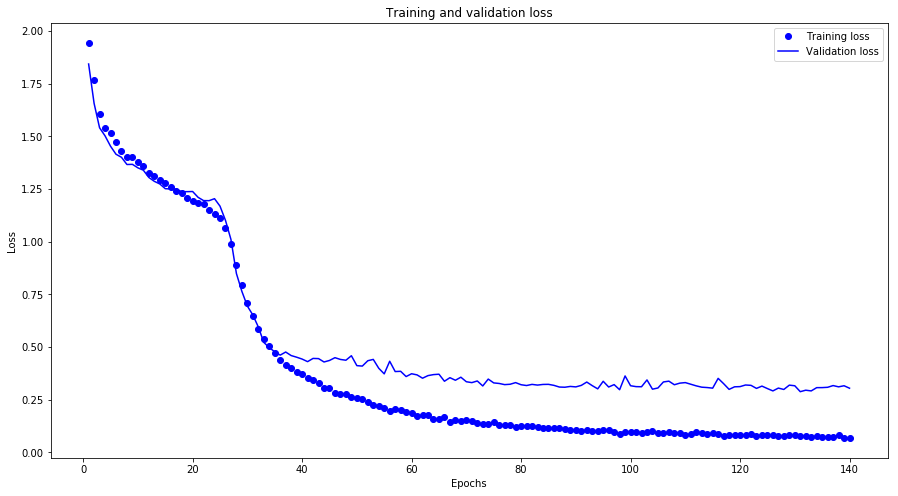

In [19]:
# Plot training vs. validation loss

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15,8

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

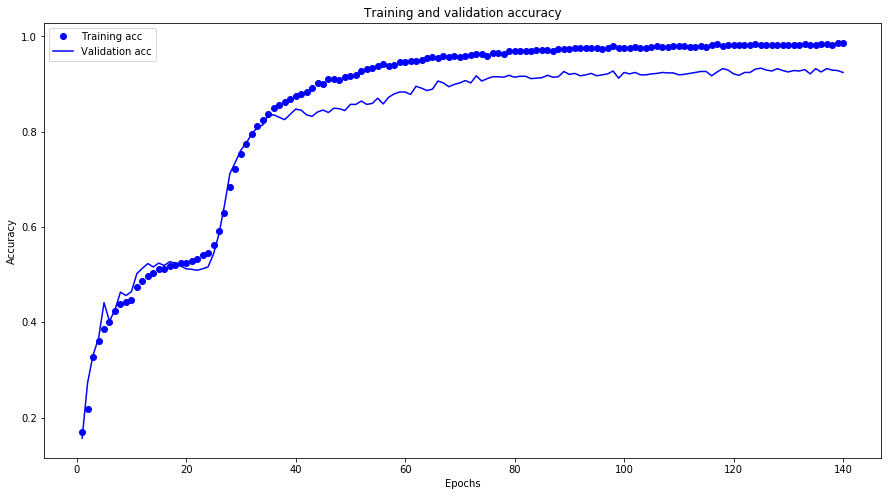

In [20]:
# Plot training vs. validation accuracy

plt.clf()   # clear figure
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Due to randomization, sometimes plots show slight overfitting and sometimes they don't. We tested multiple regularization parameters and found these to be best. In most cases, overfitting was not an issue and validation accuracy was not significantly different from training accuracy.